In [1]:
import edward as ed
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import scale
from edward.models import Normal
from keras.layers import Input, Dense
from keras.regularizers import l2
from keras import backend as K

import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
sns.set_style('white')

/Users/zihaoxu/ENTER/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def build_toy_dataset(N=20, noise_std=.1):
    np.random.seed(47)
    x = np.random.uniform(-3, 3, size=N)
    y = np.cos(x) + np.random.normal(0, noise_std * abs(x), size=N)
    x = x.astype(np.float32).reshape((N, 1))
    y = y.astype(np.float32)
    return x, y


def neural_network(x, W_0, W_1, b_0, b_1):
    h = tf.tanh(tf.matmul(x, W_0) + b_0)
    h = tf.matmul(h, W_1) + b_1
    return tf.reshape(h, [-1])

In [3]:
ed.set_seed(47)

N = 20  # number of data ponts
D = 1   # number of features

x_train, y_train = build_toy_dataset(N)

In [4]:
W_0 = Normal(loc=tf.zeros([D, 2]), scale=tf.ones([D, 2]))
W_1 = Normal(loc=tf.zeros([2, 1]), scale=tf.ones([2, 1]))
b_0 = Normal(loc=tf.zeros(2), scale=tf.ones(2))
b_1 = Normal(loc=tf.zeros(1), scale=tf.ones(1))

x = x_train
y = Normal(loc=neural_network(x, W_0, W_1, b_0, b_1),
           scale=0.1 * tf.ones(N))

In [5]:
qW_0 = Normal(loc=tf.get_variable("qW_0/loc", [D, 2]),
              scale=tf.nn.softplus(tf.get_variable("qW_0/scale", [D, 2])))
qW_1 = Normal(loc=tf.get_variable("qW_1/loc", [2, 1]),
              scale=tf.nn.softplus(tf.get_variable("qW_1/scale", [2, 1])))
qb_0 = Normal(loc=tf.get_variable("qb_0/loc", [2]),
              scale=tf.nn.softplus(tf.get_variable("qb_0/scale", [2])))
qb_1 = Normal(loc=tf.get_variable("qb_1/loc", [1]),
              scale=tf.nn.softplus(tf.get_variable("qb_1/scale", [1])))

In [6]:
# Sample functions from variational model to visualize fits.
rs = np.random.RandomState(47)
inputs = np.linspace(-5, 5, num=400, dtype=np.float32)
x = tf.expand_dims(inputs, 1)
mus = tf.stack(
    [neural_network(x, qW_0.sample(), qW_1.sample(),
                    qb_0.sample(), qb_1.sample())
     for _ in range(10)])

sess = ed.get_session()
tf.global_variables_initializer().run()
outputs = mus.eval()

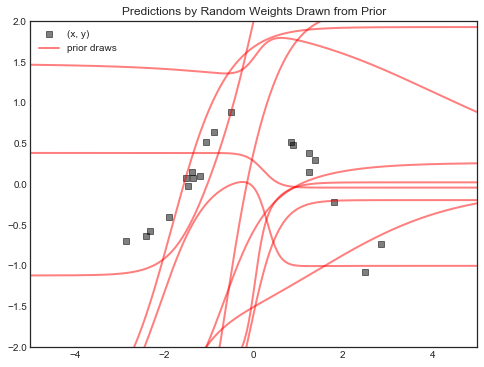

In [7]:
# FIRST VISUALIZATION (prior)
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
ax.set_title("Predictions by Random Weights Drawn from Prior")
ax.plot(x_train, y_train, 'ks', alpha=0.5, label='(x, y)')
ax.plot(inputs, outputs[0].T, 'r', lw=2, alpha=0.5, label='prior draws')
ax.plot(inputs, outputs[1:].T, 'r', lw=2, alpha=0.5)
ax.set_xlim([-5, 5])
ax.set_ylim([-2, 2])
ax.legend()
plt.savefig('../plots/prior_pred', fmt = 'png', dpi = 300)
plt.show()

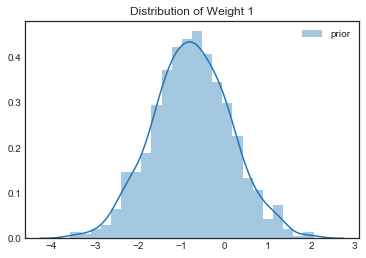

In [8]:
# Sample from prior of weights and biases in the first layer
qW_0_sample = qW_0.sample(1000).eval()

# Get the weights
weight1_pre = qW_0_sample[:, :, 0].flatten()
sns.distplot(weight1_pre, label = 'prior')
plt.title("Distribution of Weight 1")
plt.legend()
plt.show()

In [9]:
n_iter = 50

inference = ed.KLqp({W_0: qW_0, b_0: qb_0,
                     W_1: qW_1, b_1: qb_1}, data={y: y_train})
inference.run(n_iter=n_iter, n_samples=5)

/Users/zihaoxu/ENTER/lib/python3.6/site-packages/edward/util/random_variables.py:52: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  not np.issubdtype(value.dtype, np.float) and \


In [10]:
# Sample from prior of weights and biases in the first layer
qW_0_sample = qW_0.sample(1000).eval()

# Get the weights
weight1_100 = qW_0_sample[:, :, 0].flatten()

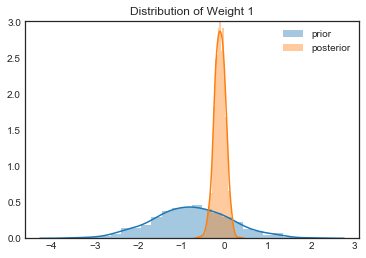

In [11]:
sns.distplot(weight1_pre, label = 'prior')
sns.distplot(weight1_100, label = 'posterior')
plt.title("Distribution of Weight 1")
plt.legend()
plt.show()

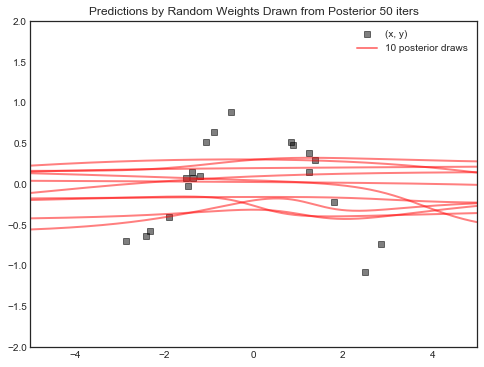

In [12]:
# SECOND VISUALIZATION (posterior)
outputs = mus.eval()

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
ax.set_title("Predictions by Random Weights Drawn from Posterior "+str(n_iter)+" iters")
ax.plot(x_train, y_train, 'ks', alpha=0.5, label='(x, y)')
ax.plot(inputs, outputs[0].T, 'r', lw=2, alpha=0.5, label='10 posterior draws')
ax.plot(inputs, outputs[1:].T, 'r', lw=2, alpha=0.5)
ax.set_xlim([-5, 5])
ax.set_ylim([-2, 2])
ax.legend()
plt.savefig('../plots/posterior_'+str(n_iter), fmt = 'png', dpi = 300)
plt.show()

In [13]:
mus = tf.stack(
    [neural_network(x, qW_0.sample(), qW_1.sample(),
                    qb_0.sample(), qb_1.sample())
     for _ in range(1000)])
outputs = mus.eval()

post25 = []
post975 = []
post_mean = []

for i in range(outputs.shape[1]):
    post25.append(np.percentile(outputs[:, i], 2.5))
    post_mean.append(np.mean(outputs[:, i]))
    post975.append(np.percentile(outputs[:, i], 97.5))

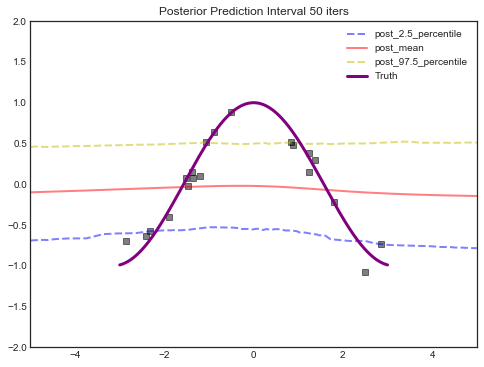

In [14]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
ax.set_title("Posterior Prediction Interval "+str(n_iter)+" iters")
ax.plot(x_train, y_train, 'ks', alpha=0.5, label=None)
ax.plot(inputs, post25, 'b', lw=2, ls = '--', alpha=0.5, label='post_2.5_percentile')
ax.plot(inputs, post_mean, 'r', lw=2, alpha=0.5, label='post_mean')
ax.plot(inputs, post975, 'y', lw=2, ls = '--', alpha=0.5, label='post_97.5_percentile')
ax.plot(np.linspace(-3, 3, num=400, dtype=np.float32), np.cos(np.linspace(-3, 3, num=400, dtype=np.float32)), c='purple', lw = 3, label = 'Truth')
ax.set_xlim([-5, 5])
ax.set_ylim([-2, 2])
ax.legend()
plt.savefig('../plots/posterior_ci_'+str(n_iter), fmt = 'png', dpi = 300)
plt.show()

In [15]:
n_iter = 300

inference = ed.KLqp({W_0: qW_0, b_0: qb_0,
                     W_1: qW_1, b_1: qb_1}, data={y: y_train})
inference.run(n_iter=n_iter-50, n_samples=5)

/Users/zihaoxu/ENTER/lib/python3.6/site-packages/edward/util/random_variables.py:52: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  not np.issubdtype(value.dtype, np.float) and \


250/250 [100%] ██████████████████████████████ Elapsed: 6s | Loss: 18.012


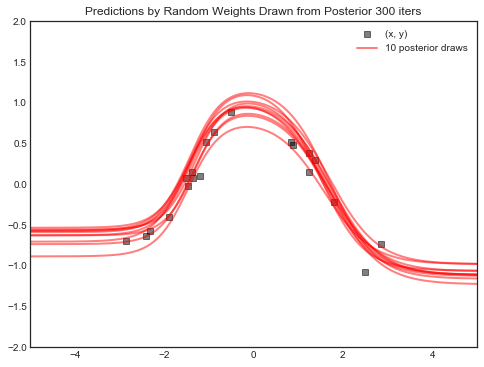

In [16]:
# SECOND VISUALIZATION (posterior)
mus = tf.stack(
    [neural_network(x, qW_0.sample(), qW_1.sample(),
                    qb_0.sample(), qb_1.sample())
     for _ in range(10)])

outputs = mus.eval()

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
ax.set_title("Predictions by Random Weights Drawn from Posterior "+str(n_iter)+" iters")
ax.plot(x_train, y_train, 'ks', alpha=0.5, label='(x, y)')
ax.plot(inputs, outputs[0].T, 'r', lw=2, alpha=0.5, label='10 posterior draws')
ax.plot(inputs, outputs[1:].T, 'r', lw=2, alpha=0.5)
ax.set_xlim([-5, 5])
ax.set_ylim([-2, 2])
ax.legend()
plt.savefig('../plots/posterior_'+str(n_iter), fmt = 'png', dpi = 300)
plt.show()

In [17]:
mus = tf.stack(
    [neural_network(x, qW_0.sample(), qW_1.sample(),
                    qb_0.sample(), qb_1.sample())
     for _ in range(1000)])
outputs = mus.eval()

In [18]:
post25 = []
post975 = []
post_mean = []
post_median = []

for i in range(outputs.shape[1]):
    post25.append(np.percentile(outputs[:, i], 2.5))
    post_mean.append(np.mean(outputs[:, i]))
    post_median.append(np.median(outputs[:, i]))
    post975.append(np.percentile(outputs[:, i], 97.5))

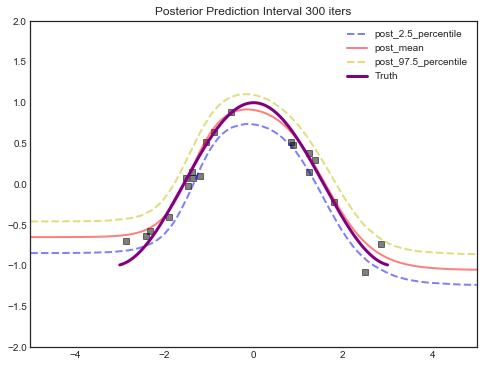

In [19]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
ax.set_title("Posterior Prediction Interval "+str(n_iter)+" iters")
ax.plot(x_train, y_train, 'ks', alpha=0.5, label=None)
ax.plot(inputs, post25, 'b', lw=2, ls = '--', alpha=0.5, label='post_2.5_percentile')
ax.plot(inputs, post_mean, 'r', lw=2, alpha=0.5, label='post_mean')
ax.plot(inputs, post975, 'y', lw=2, ls = '--', alpha=0.5, label='post_97.5_percentile')
ax.plot(np.linspace(-3, 3, num=400, dtype=np.float32), np.cos(np.linspace(-3, 3, num=400, dtype=np.float32)), c='purple', lw = 3, label = 'Truth')
ax.set_xlim([-5, 5])
ax.set_ylim([-2, 2])
ax.legend()
plt.savefig('../plots/posterior_ci_'+str(n_iter), fmt = 'png', dpi = 300)
plt.show()

In [20]:
# Sample from prior of weights and biases in the first layer
qW_0_sample = qW_0.sample(1000).eval()

# Get the weights
weight1_post = qW_0_sample[:, :, 0].flatten()

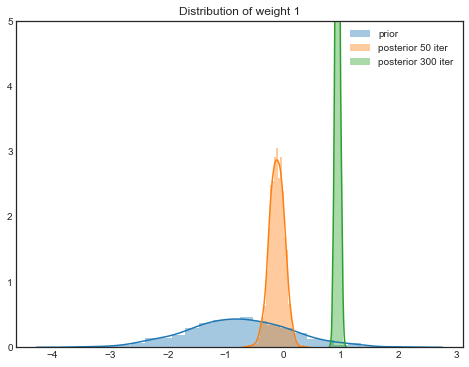

In [21]:
fig = plt.figure(figsize=(8, 6))
sns.distplot(weight1_pre, label = 'prior')
sns.distplot(weight1_100, label = 'posterior 50 iter')
sns.distplot(weight1_post, label = 'posterior 300 iter')
plt.title("Distribution of weight 1")
plt.ylim(0,5)
plt.savefig('../plots/weights_dist', fmt = 'png', dpi = 300)
plt.legend()

In [22]:
# fig, axs = plt.subplots(2,2, figsize = (14,12))
# sns.distplot(weight1_pre, ax = axs[0][0])
# sns.distplot(weight1_post, ax = axs[0][0])

# sns.distplot(weight2_pre, ax = axs[0][1])
# sns.distplot(weight2_post, ax = axs[0][1])

# sns.distplot(bias1_pre, ax = axs[1][0])
# sns.distplot(bias1_post, ax = axs[1][0])

# sns.distplot(bias2_pre, ax = axs[1][1])
# sns.distplot(bias2_post, ax = axs[1][1])